# Forecasting Electricity Prices with Amazon Chronos

**Paper:** https://arxiv.org/abs/2403.07815

**Blog post:** https://fg-research.com/blog/general/posts/electricity-forecasting-chronos.html

Install and import the dependencies.

In [1]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git fredapi pmdarima

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-r83gg2wb
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-r83gg2wb
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit eb7bdfc047de3e7af972b4ee7cf23a7968b7daa3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import warnings
import transformers
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from chronos import ChronosPipeline
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
from fredapi import Fred
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error

Download the data.

In [3]:
# set up the FRED API
fred = Fred(api_key_file="api_key.txt")

# define the time series ID
series = "APU000072610"

# download the time series
data = fred.get_series(series).rename(series).ffill()

In [4]:
data.shape

(549,)

In [5]:
data.head()

1978-11-01    0.046
1978-12-01    0.046
1979-01-01    0.046
1979-02-01    0.047
1979-03-01    0.047
Name: APU000072610, dtype: float64

In [6]:
data.tail()

2024-03-01    0.174
2024-04-01    0.173
2024-05-01    0.175
2024-06-01    0.178
2024-07-01    0.178
Name: APU000072610, dtype: float64

Visualize the data.

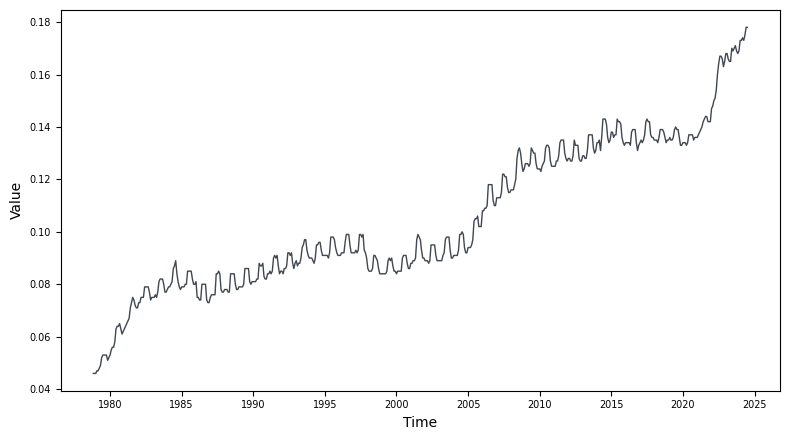

In [7]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(data, color="#3f4751", lw=1)
ax.set(xlabel="Time", ylabel="Value")
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.tight_layout()
fig.show()

Define the start and end dates of the forecasts.

In [8]:
start_date = "2014-08-01"
end_date = "2024-07-01"

## SARIMA

Find the best model.

In [9]:
best_sarima_model = auto_arima(
    y=data[data.index < start_date],
    start_p=0,
    start_q=0,
    start_P=0,
    start_Q=0,
    m=12,
    seasonal=True,
)

In [10]:
print(best_sarima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  429
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                2297.256
Date:                              Fri, 23 Aug 2024   AIC                          -4588.512
Time:                                      17:05:54   BIC                          -4576.335
Sample:                                  11-01-1978   HQIC                         -4583.703
                                       - 07-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9918      0.005    191.785      0.000       0.982       1.002
ma.S.L12      -0.74

Generate the one-step-ahead forecasts.

In [11]:
# save the start time
start_time = datetime.now()

# create a list for storing the forecasts
sarima_forecasts = []

# loop across the dates
for t in tqdm(range(data.index.get_loc(start_date), data.index.get_loc(end_date) + 1)):

    # extract the training data
    context = data.iloc[:t]

    # train the model
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sarima_model = SARIMAX(
            endog=context,
            order=best_sarima_model.order,
            seasonal_order=best_sarima_model.seasonal_order,
            trend="c" if best_sarima_model.with_intercept else None,
        ).fit(disp=0)

    # generate the one-step-ahead forecast
    sarima_forecast = sarima_model.get_forecast(steps=1)

    # save the forecast
    sarima_forecasts.append({
        "date": data.index[t],
        "actual": data.values[t],
        "mean": sarima_forecast.predicted_mean.item(),
        "std": sarima_forecast.var_pred_mean.item() ** 0.5,
    })

# cast the forecasts to data frame
sarima_forecasts = pd.DataFrame(sarima_forecasts)

# save the end time
end_time = datetime.now()

print(f"\nRunning time of SARIMA model: {end_time - start_time}")

100%|██████████| 120/120 [00:41<00:00,  2.90it/s]


Running time of SARIMA model: 0:00:41.344962


In [12]:
sarima_forecasts.shape

(120, 4)

In [13]:
sarima_forecasts.head()

,date,actual,mean,std
0,2014-08-01,0.143,0.142941,0.001095
1,2014-09-01,0.141,0.143001,0.001372
2,2014-10-01,0.136,0.137551,0.001368
3,2014-11-01,0.134,0.134520,0.001372
4,2014-12-01,0.135,0.134148,0.001099


In [14]:
sarima_forecasts.tail()

,date,actual,mean,std
115,2024-03-01,0.174,0.172814,0.001154
116,2024-04-01,0.173,0.173907,0.001154
117,2024-05-01,0.175,0.174130,0.001154
118,2024-06-01,0.178,0.179222,0.001153
119,2024-07-01,0.178,0.178771,0.001153


Visualize the forecasts.

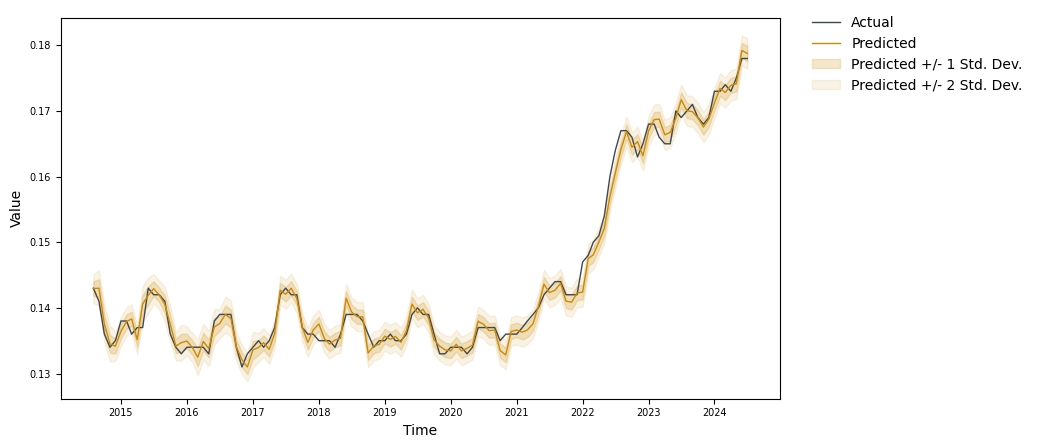

In [15]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(sarima_forecasts["date"].values, sarima_forecasts["actual"].values, color="#3f4751", lw=1, label="Actual")
ax.plot(sarima_forecasts["date"].values, sarima_forecasts["mean"].values, color="#ca8a04", lw=1, label="Predicted")
ax.fill_between(sarima_forecasts["date"].values, sarima_forecasts["mean"].values + sarima_forecasts["std"].values, sarima_forecasts["mean"].values - sarima_forecasts["std"].values, color="#ca8a04", alpha=0.2, lw=1, label="Predicted +/- 1 Std. Dev.")
ax.fill_between(sarima_forecasts["date"].values, sarima_forecasts["mean"].values + 2 * sarima_forecasts["std"].values, sarima_forecasts["mean"].values - 2 * sarima_forecasts["std"].values, color="#ca8a04", alpha=0.1, lw=1, label="Predicted +/- 2 Std. Dev.")
ax.set(xlabel="Time", ylabel="Value")
ax.xaxis.set_tick_params(labelbottom=True)
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.legend(bbox_to_anchor=(1, 0, 0.3, 1), frameon=False)
fig.tight_layout()
fig.show()

Evaluate the forecasts.

In [16]:
sarima_metrics = pd.DataFrame(
    columns=["Metric", "Value"],
    data=[
        {"Metric": "RMSE", "Value": root_mean_squared_error(y_true=sarima_forecasts["actual"], y_pred=sarima_forecasts["mean"])},
        {"Metric": "MAE", "Value": mean_absolute_error(y_true=sarima_forecasts["actual"], y_pred=sarima_forecasts["mean"])},
    ]
).set_index("Metric")

In [17]:
sarima_metrics

,Value
Metric,
RMSE,0.001364
MAE,0.001067


## Chronos

Instantiate the model.

In [18]:
chronos_model = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

Generate the one-step-ahead forecasts.

In [19]:
# save the start time
start_time = datetime.now()

# create a list for storing the forecasts
chronos_forecasts = []

# loop across the dates
for t in tqdm(range(data.index.get_loc(start_date), data.index.get_loc(end_date) + 1)):

    # extract the context window
    context = data.iloc[:t]

    # generate the one-step-ahead forecast
    transformers.set_seed(42)
    chronos_forecast = chronos_model.predict(
        context=torch.from_numpy(context.values),
        prediction_length=1,
        num_samples=100
    ).detach().cpu().numpy().flatten()

    # save the forecasts
    chronos_forecasts.append({
        "date": data.index[t],
        "actual": data.values[t],
        "mean": np.mean(chronos_forecast),
        "std": np.std(chronos_forecast, ddof=1),
    })

# cast the forecasts to data frame
chronos_forecasts = pd.DataFrame(chronos_forecasts)

# save the end time
end_time = datetime.now()

print(f"\nRunning time of Chronos model: {end_time - start_time}")

100%|██████████| 120/120 [03:27<00:00,  1.73s/it]


Running time of Chronos model: 0:03:27.037273


In [20]:
chronos_forecasts.shape

(120, 4)

In [21]:
chronos_forecasts.head()

,date,actual,mean,std
0,2014-08-01,0.143,0.143660,0.001834
1,2014-09-01,0.141,0.143642,0.001807
2,2014-10-01,0.136,0.135414,0.002020
3,2014-11-01,0.134,0.134580,0.001381
4,2014-12-01,0.135,0.134469,0.001113


In [22]:
chronos_forecasts.tail()

,date,actual,mean,std
115,2024-03-01,0.174,0.172770,0.001834
116,2024-04-01,0.173,0.173915,0.001878
117,2024-05-01,0.175,0.173806,0.001996
118,2024-06-01,0.178,0.181567,0.002521
119,2024-07-01,0.178,0.178896,0.002522


Visualize the forecasts.

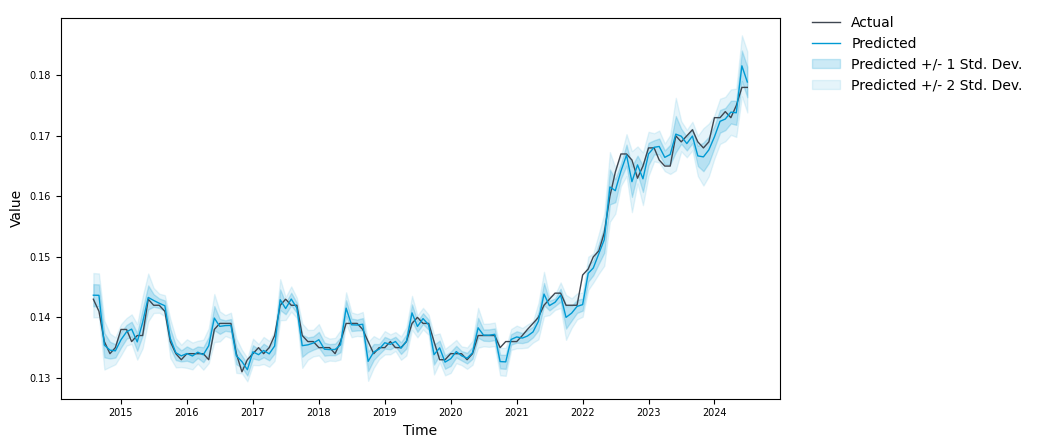

In [23]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(chronos_forecasts["date"].values, chronos_forecasts["actual"].values, color="#3f4751", lw=1, label="Actual")
ax.plot(chronos_forecasts["date"].values, chronos_forecasts["mean"].values, color="#009ad3", lw=1, label="Predicted")
ax.fill_between(chronos_forecasts["date"].values, chronos_forecasts["mean"].values + chronos_forecasts["std"].values, chronos_forecasts["mean"].values - chronos_forecasts["std"].values, color="#009ad3", alpha=0.2, lw=1, label="Predicted +/- 1 Std. Dev.")
ax.fill_between(chronos_forecasts["date"].values, chronos_forecasts["mean"].values + 2 * chronos_forecasts["std"].values, chronos_forecasts["mean"].values - 2 * chronos_forecasts["std"].values, color="#009ad3", alpha=0.1, lw=1, label="Predicted +/- 2 Std. Dev.")
ax.set(xlabel="Time", ylabel="Value")
ax.xaxis.set_tick_params(labelbottom=True)
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.legend(bbox_to_anchor=(1, 0, 0.3, 1), frameon=False)
fig.tight_layout()
fig.show()

Evaluate the forecasts.

In [24]:
chronos_metrics = pd.DataFrame(
    columns=["Metric", "Value"],
    data=[
        {"Metric": "RMSE", "Value": root_mean_squared_error(y_true=chronos_forecasts["actual"], y_pred=chronos_forecasts["mean"])},
        {"Metric": "MAE", "Value": mean_absolute_error(y_true=chronos_forecasts["actual"], y_pred=chronos_forecasts["mean"])},
    ]
).set_index("Metric")

In [25]:
chronos_metrics

,Value
Metric,
RMSE,0.001443
MAE,0.001105
